---
# Clustering NBA Players: From Performance Metrics to Strategic Insights

## Business Context: NBA Roster Construction as a Clustering Problem

NBA teams face a complex optimization challenge: how to build the most effective roster with limited resources (salary cap ~$140M). Traditional positions (PG, SG, SF, PF, C) tell only part of the story. What if we could discover natural player archetypes based on actual performance data?

**Strategic Questions:**
1. What distinct player types naturally exist in the NBA?
2. How can teams identify undervalued players who fit specific archetypes?
3. Which combinations of archetypes create winning teams?
4. How do we move beyond traditional positions to performance-based roles?

Today we'll use clustering to transform raw performance statistics into actionable business insights for NBA front offices.

In [ ]:
#| label: setup
#| warning: false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🏀 NBA Clustering Analysis: From Data to Strategic Insights")
print("="*60)

🏀 NBA Clustering Analysis: From Data to Strategic Insights


# Section 1: Business Motivation & Data Understanding

## Loading and Exploring Our Business Data

In [ ]:
#| label: data-loading

# Load the NBA dataset
nba_url = 'https://raw.githubusercontent.com/aaubs/ds-master/main/data/NBA_Data.csv'
nba_raw = pd.read_csv(nba_url)

print(f"Dataset loaded: {nba_raw.shape[0]} players, {nba_raw.shape[1]} performance metrics")
print(f"\nColumns in our dataset:")
for i, col in enumerate(nba_raw.columns, 1):
    print(f"{i:2d}. {col}")

Dataset loaded: 530 players, 30 performance metrics

Columns in our dataset:
 1. Unnamed: 0
 2. PLAYER
 3. TEAM
 4. AGE
 5. GP
 6. W
 7. L
 8. MIN
 9. PTS
10. FGM
11. FGA
12. FG%
13. 3PM
14. 3PA
15. 3P%
16. FTM
17. FTA
18. FT%
19. OREB
20. DREB
21. REB
22. AST
23. TOV
24. STL
25. BLK
26. PF
27. FP
28. DD2
29. TD3
30. +/-


In [ ]:
#| label: initial-exploration

# Get a business-focused view of our data
print("📋 Sample Player Records:")
display_cols = ['PLAYER', 'TEAM', 'PTS', 'REB', 'AST', 'FG%', '3P%', 'FT%']
print(nba_raw[display_cols].head(10))

print(f"\n📊 Performance Statistics Summary:")
performance_cols = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FG%', '3P%']
print(nba_raw[performance_cols].describe().round(2))

📋 Sample Player Records:
                  PLAYER TEAM   PTS   REB  AST   FG%   3P%   FT%
0           James Harden  HOU  36.1   6.6  7.5  44.2  36.8  87.9
1            Paul George  OKC  28.0   8.2  4.1  43.8  38.6  83.9
2  Giannis Antetokounmpo  MIL  27.7  12.5  5.9  57.8  25.6  72.9
3            Joel Embiid  PHI  27.5  13.6  3.7  48.4  30.0  80.4
4           LeBron James  LAL  27.4   8.5  8.3  51.0  33.9  66.5
5          Stephen Curry  GSW  27.3   5.3  5.2  47.2  43.7  91.6
6          Kawhi Leonard  TOR  26.6   7.3  3.3  49.6  37.1  85.4
7           Devin Booker  PHX  26.6   4.1  6.8  46.7  32.6  86.6
8           Kevin Durant  GSW  26.0   6.4  5.9  52.1  35.3  88.5
9          Anthony Davis  NOP  25.9  12.0  3.9  51.7  33.1  79.4

📊 Performance Statistics Summary:
          PTS     REB     AST     STL     BLK     FG%     3P%
count  530.00  530.00  530.00  530.00  530.00  530.00  530.00
mean     8.61    3.61    1.92    0.62    0.39   43.99   29.03
std      6.11    2.54    1.77    0.41  

## Business Question: What Dimensions Define Playing Styles?

Before clustering, let's understand what might naturally separate players into different archetypes.

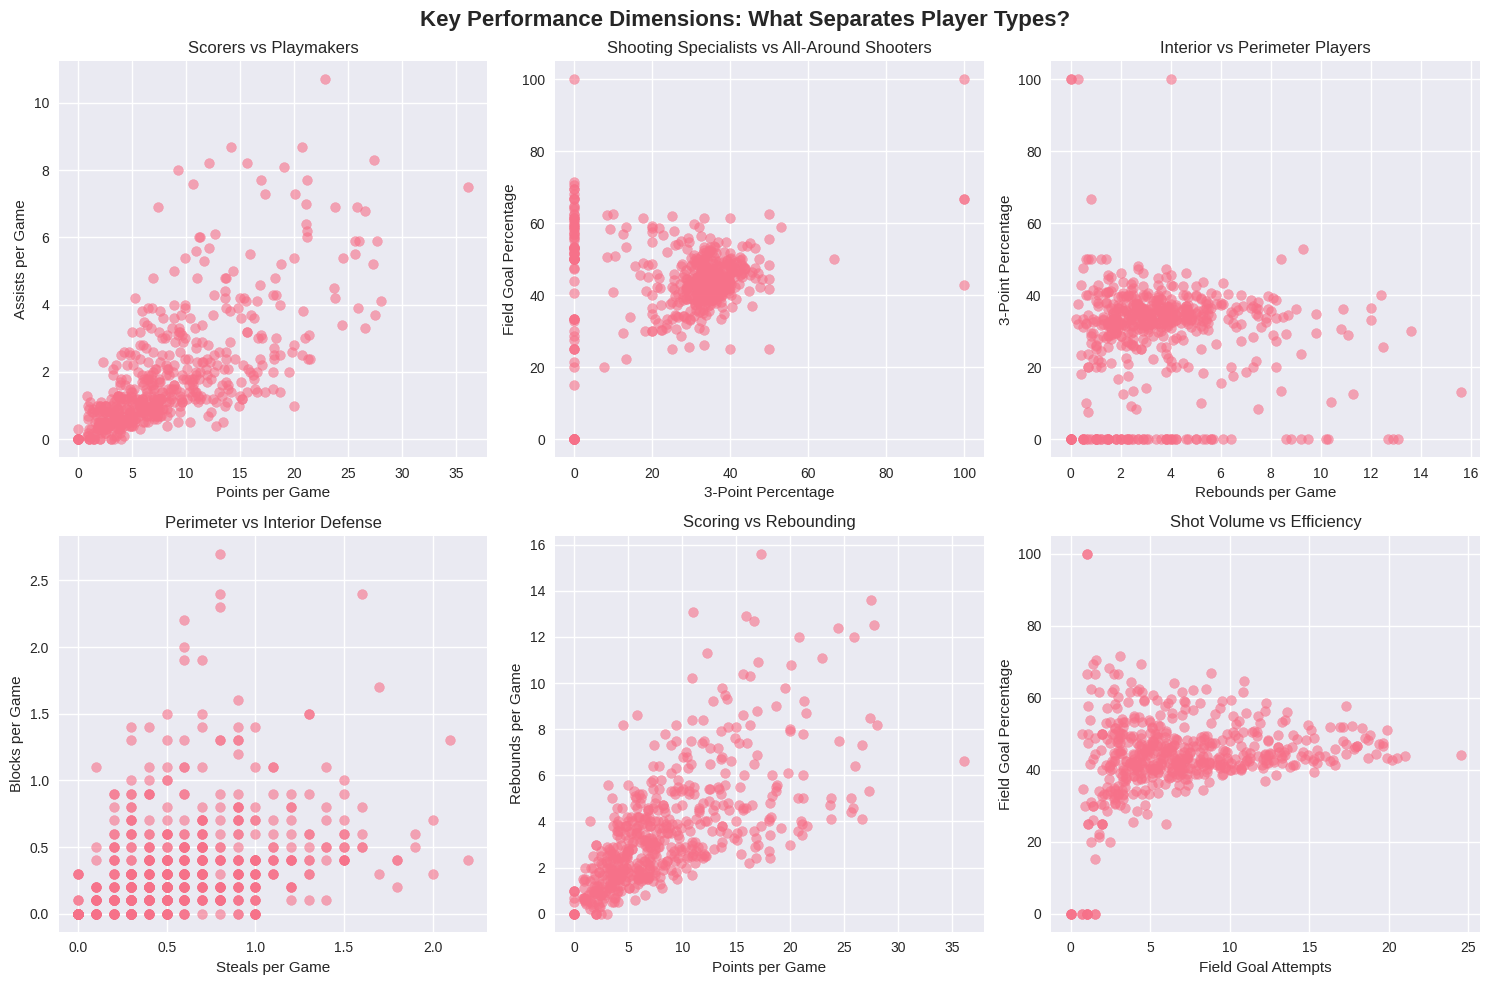

💡 Business Insight: We can see natural separations that might define archetypes:
   • High scorers vs high assist players (different offensive roles)
   • Interior players (high rebounds, low 3P%) vs perimeter players
   • Different defensive specializations (steals vs blocks)
   • Volume shooters vs efficient shooters


In [ ]:
#| label: business-dimensions

# Explore key performance relationships that might define player types
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Key Performance Dimensions: What Separates Player Types?', fontsize=16, fontweight='bold')

# Scoring vs Playmaking
axes[0,0].scatter(nba_raw['PTS'], nba_raw['AST'], alpha=0.6, s=50)
axes[0,0].set_xlabel('Points per Game')
axes[0,0].set_ylabel('Assists per Game')
axes[0,0].set_title('Scorers vs Playmakers')

# Shooting efficiency
axes[0,1].scatter(nba_raw['3P%'], nba_raw['FG%'], alpha=0.6, s=50)
axes[0,1].set_xlabel('3-Point Percentage')
axes[0,1].set_ylabel('Field Goal Percentage')
axes[0,1].set_title('Shooting Specialists vs All-Around Shooters')

# Interior vs Perimeter
axes[0,2].scatter(nba_raw['REB'], nba_raw['3P%'], alpha=0.6, s=50)
axes[0,2].set_xlabel('Rebounds per Game')
axes[0,2].set_ylabel('3-Point Percentage')
axes[0,2].set_title('Interior vs Perimeter Players')

# Defensive impact
axes[1,0].scatter(nba_raw['STL'], nba_raw['BLK'], alpha=0.6, s=50)
axes[1,0].set_xlabel('Steals per Game')
axes[1,0].set_ylabel('Blocks per Game')
axes[1,0].set_title('Perimeter vs Interior Defense')

# Overall production
axes[1,1].scatter(nba_raw['PTS'], nba_raw['REB'], alpha=0.6, s=50)
axes[1,1].set_xlabel('Points per Game')
axes[1,1].set_ylabel('Rebounds per Game')
axes[1,1].set_title('Scoring vs Rebounding')

# Efficiency vs Volume
axes[1,2].scatter(nba_raw['FGA'], nba_raw['FG%'], alpha=0.6, s=50)
axes[1,2].set_xlabel('Field Goal Attempts')
axes[1,2].set_ylabel('Field Goal Percentage')
axes[1,2].set_title('Shot Volume vs Efficiency')

plt.tight_layout()
plt.show()

print("💡 Business Insight: We can see natural separations that might define archetypes:")
print("   • High scorers vs high assist players (different offensive roles)")
print("   • Interior players (high rebounds, low 3P%) vs perimeter players")
print("   • Different defensive specializations (steals vs blocks)")
print("   • Volume shooters vs efficient shooters")

## Data Preparation: Setting Up for Business Success

Clustering algorithms are sensitive to scale - we can't let salary dominate other metrics just because it's measured in millions while games played is measured in tens.

In [ ]:
#| label: data-preparation

# Select performance metrics most relevant to playing style
# Focus on per-game statistics that define how a player contributes
performance_metrics = [
    'PTS',   # Scoring
    'REB',   # Rebounding
    'AST',   # Playmaking
    'STL',   # Perimeter defense
    'BLK',   # Interior defense
    'FG%',   # Shooting efficiency
    '3P%',   # Perimeter shooting
    'FT%'    # Free throw shooting
]

# Create our analysis dataset
nba_analysis = nba_raw[['PLAYER', 'TEAM'] + performance_metrics].copy()

# Handle missing values (business decision: players with incomplete data removed)
print(f"Missing values per metric:")
missing_counts = nba_analysis[performance_metrics].isnull().sum()
print(missing_counts[missing_counts > 0])

# Remove players with any missing performance data
nba_clean = nba_analysis.dropna()
print(f"\nDataset after removing incomplete records: {nba_clean.shape[0]} players")

# Prepare features for clustering
features = nba_clean[performance_metrics].copy()

print(f"\n📊 Performance Metrics Summary (Clean Dataset):")
print(features.describe().round(3))

Missing values per metric:
Series([], dtype: int64)

Dataset after removing incomplete records: 530 players

📊 Performance Metrics Summary (Clean Dataset):
           PTS      REB      AST      STL      BLK      FG%      3P%      FT%
count  530.000  530.000  530.000  530.000  530.000  530.000  530.000  530.000
mean     8.614    3.613    1.922    0.618    0.391   43.991   29.028   69.678
std      6.110    2.535    1.775    0.413    0.405   11.182   14.938   21.488
min      0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
25%      4.000    1.800    0.725    0.300    0.100   40.200   25.650   65.150
50%      7.000    3.100    1.300    0.500    0.300   43.850   33.150   75.000
75%     11.675    4.700    2.500    0.900    0.500   48.950   36.775   81.800
max     36.100   15.600   10.700    2.200    2.700  100.000  100.000  100.000


In [ ]:
#| label: feature-scaling

# Business rationale for scaling: All metrics should contribute equally
# Without scaling, points (0-30+ range) would dominate percentages (0-1 range)

print("🎯 Why Scaling Matters for Business Insights:")
print("Before scaling - Range of each metric:")
for col in performance_metrics:
    print(f"   {col}: {features[col].min():.3f} to {features[col].max():.3f}")

# Apply StandardScaler (zero mean, unit variance)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=performance_metrics, index=features.index)

print(f"\nAfter scaling - All metrics have mean ≈ 0, std ≈ 1:")
print(features_scaled_df.describe().round(3))

print("\n💼 Business Impact:")
print("   • Now all performance dimensions contribute equally to player similarity")
print("   • Clustering won't be dominated by high-magnitude metrics")
print("   • Results will reflect basketball skills, not statistical scales")

🎯 Why Scaling Matters for Business Insights:
Before scaling - Range of each metric:
   PTS: 0.000 to 36.100
   REB: 0.000 to 15.600
   AST: 0.000 to 10.700
   STL: 0.000 to 2.200
   BLK: 0.000 to 2.700
   FG%: 0.000 to 100.000
   3P%: 0.000 to 100.000
   FT%: 0.000 to 100.000

After scaling - All metrics have mean ≈ 0, std ≈ 1:
           PTS      REB      AST      STL      BLK      FG%      3P%      FT%
count  530.000  530.000  530.000  530.000  530.000  530.000  530.000  530.000
mean    -0.000    0.000    0.000   -0.000    0.000   -0.000   -0.000    0.000
std      1.001    1.001    1.001    1.001    1.001    1.001    1.001    1.001
min     -1.411   -1.426   -1.084   -1.497   -0.966   -3.938   -1.945   -3.246
25%     -0.756   -0.716   -0.675   -0.770   -0.719   -0.339   -0.226   -0.211
50%     -0.264   -0.203   -0.351   -0.285   -0.225   -0.013    0.276    0.248
75%      0.501    0.429    0.326    0.684    0.268    0.444    0.519    0.565
max      4.503    4.732    4.951    3.834    5

## Setting the Stage: Our Clustering Journey

Now we have clean, scaled performance data for clustering analysis. Let's establish our roadmap:

In [ ]:
#| label: analysis-roadmap

print("🗺️  Our Clustering Analysis Roadmap:")
print("="*50)
print("1. HIERARCHICAL CLUSTERING (Discovery Phase)")
print("   → Explore: How many natural player types exist?")
print("   → Understand: What relationships exist between players?")
print("   → Decide: What number of clusters makes business sense?")
print()
print("2. K-MEANS CLUSTERING (Decision Phase)")
print("   → Apply: Create clean, actionable player segments")
print("   → Optimize: Find the best boundaries for our chosen k")
print("   → Validate: Ensure results make basketball sense")
print()
print("3. BUSINESS TRANSLATION (Impact Phase)")
print("   → Interpret: What does each archetype represent?")
print("   → Recommend: How should teams use these insights?")
print("   → Apply: Framework for roster construction decisions")
print()
print(f"Ready to analyze {nba_clean.shape[0]} NBA players across {len(performance_metrics)} performance dimensions!")

🗺️  Our Clustering Analysis Roadmap:
1. HIERARCHICAL CLUSTERING (Discovery Phase)
   → Explore: How many natural player types exist?
   → Understand: What relationships exist between players?
   → Decide: What number of clusters makes business sense?

2. K-MEANS CLUSTERING (Decision Phase)
   → Apply: Create clean, actionable player segments
   → Optimize: Find the best boundaries for our chosen k
   → Validate: Ensure results make basketball sense

3. BUSINESS TRANSLATION (Impact Phase)
   → Interpret: What does each archetype represent?
   → Recommend: How should teams use these insights?
   → Apply: Framework for roster construction decisions

Ready to analyze 530 NBA players across 8 performance dimensions!


# Section 2: Hierarchical Clustering - Discovering Player Archetypes

## The Business Question: How Many Natural Player Types Exist?

Hierarchical clustering helps us discover the natural structure in our data without pre-deciding how many player types exist. Think of it as building a family tree of player similarities.

In [ ]:
#| label: hierarchical-setup

print("🌳 HIERARCHICAL CLUSTERING: Building the Player Family Tree")
print("="*60)
print("Business Approach: Start with each player as their own 'segment',")
print("then systematically merge the most similar players until we have one big group.")
print()
print("Key Advantage: We can explore multiple clustering solutions and choose")
print("the one that makes the most business sense.")

🌳 HIERARCHICAL CLUSTERING: Building the Player Family Tree
Business Approach: Start with each player as their own 'segment',
then systematically merge the most similar players until we have one big group.

Key Advantage: We can explore multiple clustering solutions and choose
the one that makes the most business sense.


## Small Example: Understanding the Algorithm

Let's start with a small example to see how the algorithm works, then scale to the full dataset.

In [ ]:
#| label: small-example-setup

# Select 8 well-known players for illustration (if they exist in our dataset)
example_players = nba_clean.head(8)[['PLAYER'] + performance_metrics].copy()
example_players_scaled = features_scaled_df.head(8)

print("🔍 Small Example: Understanding Hierarchical Clustering")
print("Sample players for algorithm demonstration:")
print(example_players[['PLAYER', 'PTS', 'REB', 'AST', 'FG%']].round(2))

🔍 Small Example: Understanding Hierarchical Clustering
Sample players for algorithm demonstration:
                  PLAYER   PTS   REB  AST   FG%
0           James Harden  36.1   6.6  7.5  44.2
1            Paul George  28.0   8.2  4.1  43.8
2  Giannis Antetokounmpo  27.7  12.5  5.9  57.8
3            Joel Embiid  27.5  13.6  3.7  48.4
4           LeBron James  27.4   8.5  8.3  51.0
5          Stephen Curry  27.3   5.3  5.2  47.2
6          Kawhi Leonard  26.6   7.3  3.3  49.6
7           Devin Booker  26.6   4.1  6.8  46.7


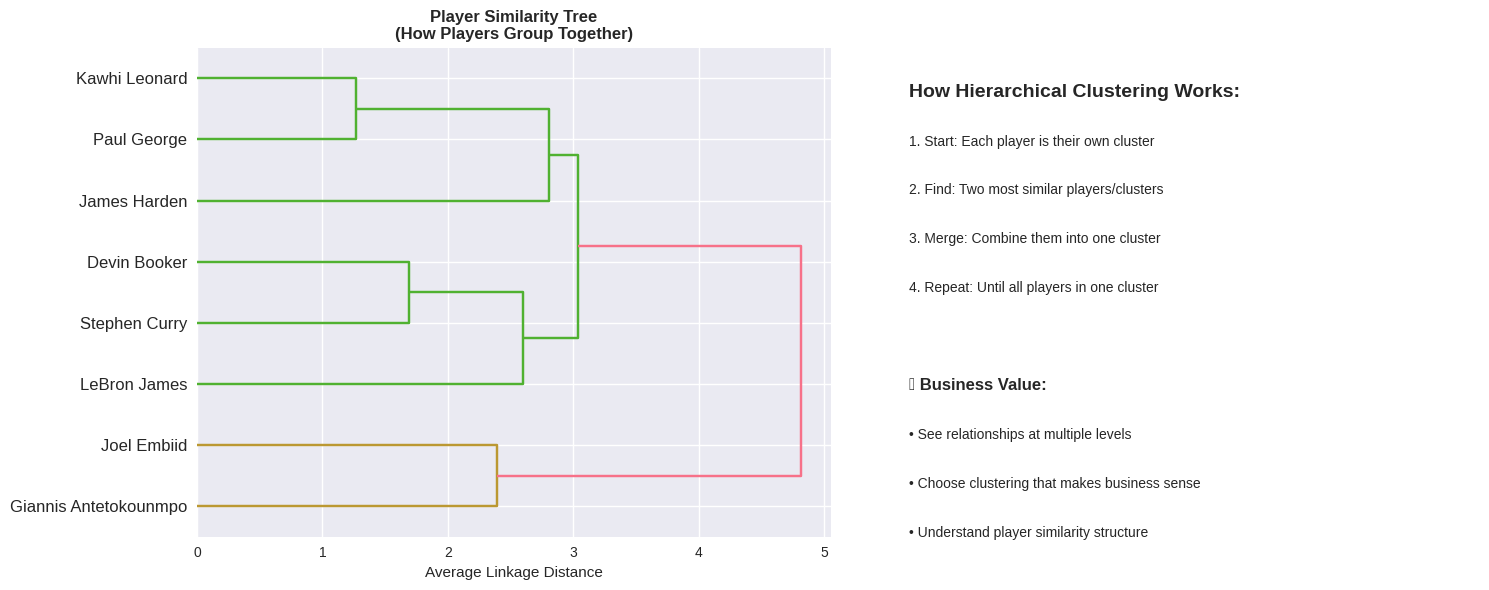

📊 Reading the Dendrogram:
• Height = Dissimilarity when clusters were merged
• Horizontal lines = Different possible cluster solutions
• Large height jumps = Natural breaking points


In [ ]:
#| label: hierarchical-small-example

# Demonstrate hierarchical clustering with small example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Perform hierarchical clustering on small example
linkage_matrix_small = linkage(example_players_scaled, method='average')

# Create dendrogram
dendrogram(linkage_matrix_small,
           labels=example_players['PLAYER'].values,
           orientation='right',
           ax=ax1)
ax1.set_title('Player Similarity Tree\n(How Players Group Together)', fontweight='bold')
ax1.set_xlabel('Average Linkage Distance')

# Show the iterative merging process
ax2.text(0.1, 0.9, 'How Hierarchical Clustering Works:', fontsize=14, fontweight='bold', transform=ax2.transAxes)
ax2.text(0.1, 0.8, '1. Start: Each player is their own cluster', transform=ax2.transAxes)
ax2.text(0.1, 0.7, '2. Find: Two most similar players/clusters', transform=ax2.transAxes)
ax2.text(0.1, 0.6, '3. Merge: Combine them into one cluster', transform=ax2.transAxes)
ax2.text(0.1, 0.5, '4. Repeat: Until all players in one cluster', transform=ax2.transAxes)
ax2.text(0.1, 0.4, '', transform=ax2.transAxes)
ax2.text(0.1, 0.3, '🎯 Business Value:', fontsize=12, fontweight='bold', transform=ax2.transAxes)
ax2.text(0.1, 0.2, '• See relationships at multiple levels', transform=ax2.transAxes)
ax2.text(0.1, 0.1, '• Choose clustering that makes business sense', transform=ax2.transAxes)
ax2.text(0.1, 0.0, '• Understand player similarity structure', transform=ax2.transAxes)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

plt.tight_layout()
plt.show()

print("📊 Reading the Dendrogram:")
print("• Height = Dissimilarity when clusters were merged")
print("• Horizontal lines = Different possible cluster solutions")
print("• Large height jumps = Natural breaking points")

## Full Dataset Analysis: Discovering NBA Archetypes

Now let's apply hierarchical clustering to our full NBA dataset to discover natural player archetypes.

🏀 Full Dataset Hierarchical Analysis
----------------------------------------


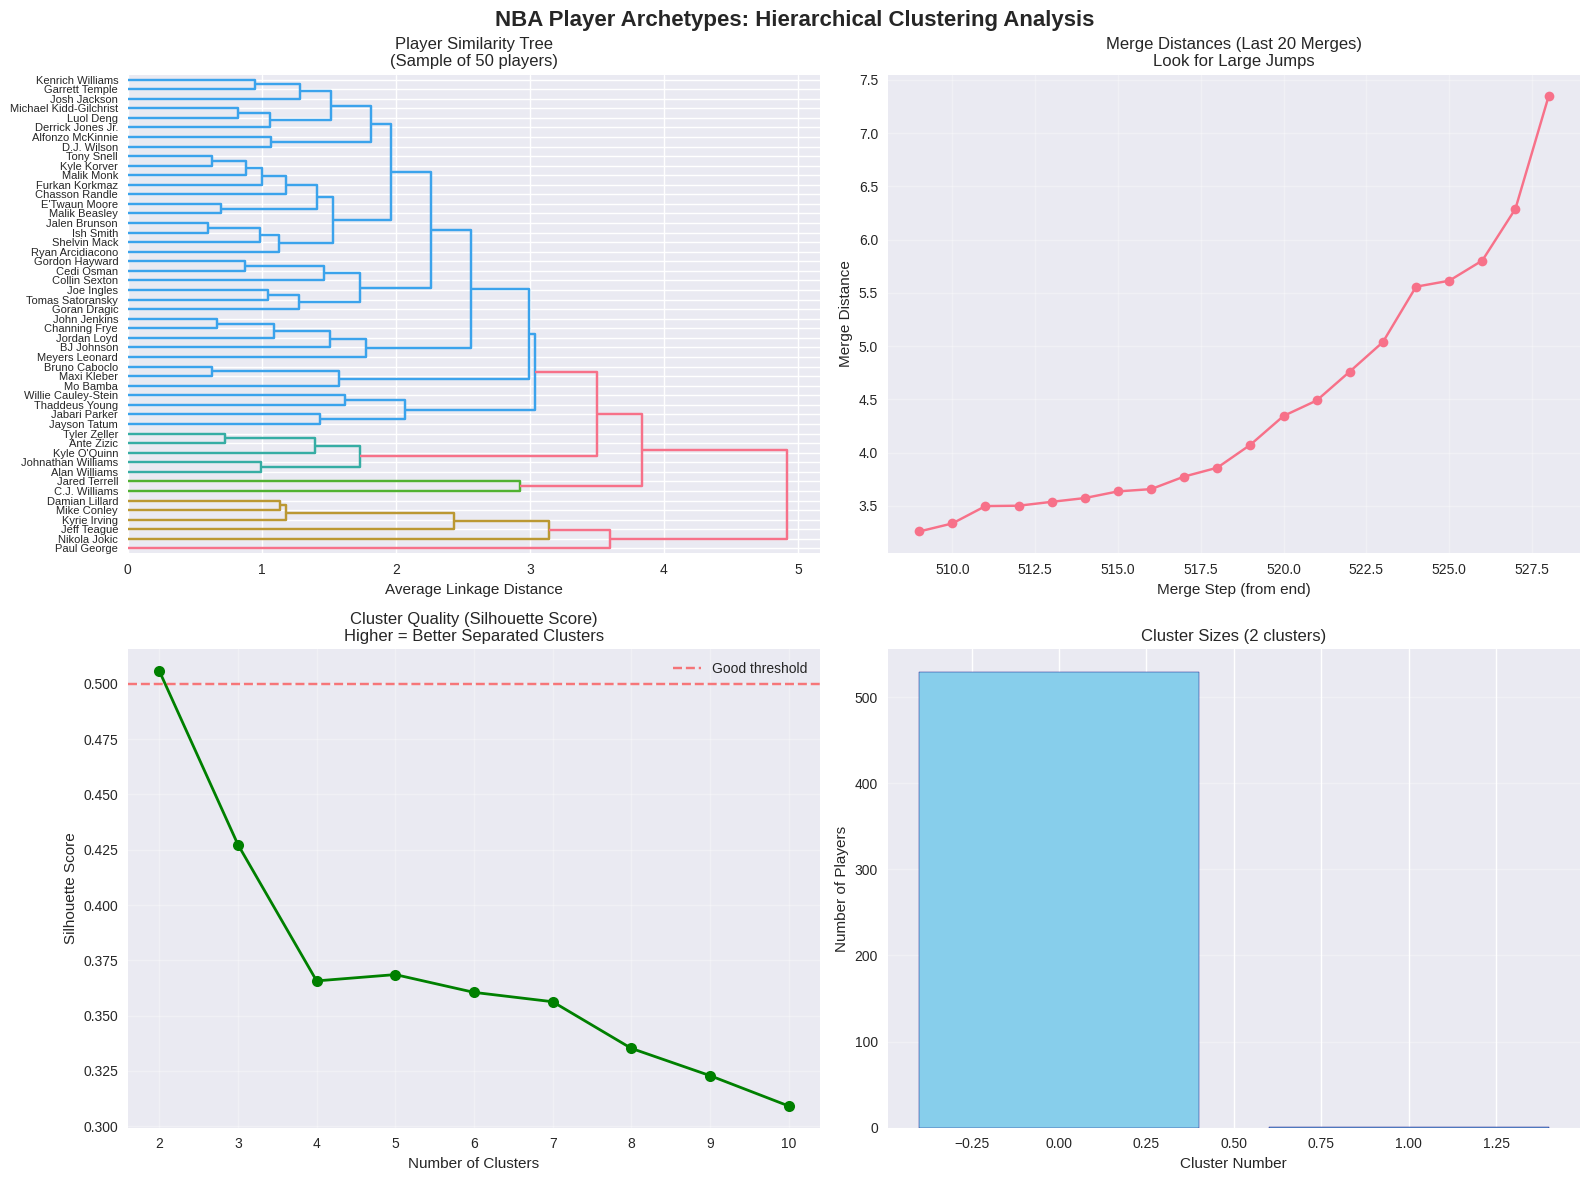

📈 Optimal number of clusters (by silhouette score): 2
📊 Silhouette score: 0.506
📋 Cluster sizes: [529   1]


In [ ]:
#| label: hierarchical-full-analysis

print("🏀 Full Dataset Hierarchical Analysis")
print("-" * 40)

# Perform hierarchical clustering on full dataset
# Use a sample for visualization (dendrograms get messy with 400+ players)
sample_size = 50
sample_indices = np.random.choice(len(features_scaled_df), sample_size, replace=False)
sample_data = features_scaled_df.iloc[sample_indices]
sample_players = nba_clean.iloc[sample_indices]

# Create linkage matrix
linkage_matrix_full = linkage(features_scaled, method='average')
linkage_matrix_sample = linkage(sample_data, method='average')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NBA Player Archetypes: Hierarchical Clustering Analysis', fontsize=16, fontweight='bold')

# Sample dendrogram for visualization
dendrogram(linkage_matrix_sample,
          labels=sample_players['PLAYER'].values,
          orientation='right',
          ax=ax1,
          leaf_font_size=8)
ax1.set_title(f'Player Similarity Tree\n(Sample of {sample_size} players)')
ax1.set_xlabel('Average Linkage Distance')

# Elbow plot equivalent for hierarchical clustering
distances = linkage_matrix_full[:, 2]  # Get merge distances
ax2.plot(range(len(distances)-20, len(distances)), distances[-20:], 'o-')
ax2.set_title('Merge Distances (Last 20 Merges)\nLook for Large Jumps')
ax2.set_xlabel('Merge Step (from end)')
ax2.set_ylabel('Merge Distance')
ax2.grid(True, alpha=0.3)

# Try different numbers of clusters and evaluate
cluster_range = range(2, 11)
silhouette_scores_hier = []

for n_clusters in cluster_range:
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    cluster_labels = hierarchical.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores_hier.append(silhouette_avg)

ax3.plot(cluster_range, silhouette_scores_hier, 'o-', color='green', linewidth=2, markersize=8)
ax3.set_title('Cluster Quality (Silhouette Score)\nHigher = Better Separated Clusters')
ax3.set_xlabel('Number of Clusters')
ax3.set_ylabel('Silhouette Score')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Good threshold')
ax3.legend()

# Show cluster sizes for optimal number
optimal_clusters_hier = cluster_range[np.argmax(silhouette_scores_hier)]
hierarchical_final = AgglomerativeClustering(n_clusters=optimal_clusters_hier, linkage='average')
cluster_labels_hier = hierarchical_final.fit_predict(features_scaled)

cluster_sizes = pd.Series(cluster_labels_hier).value_counts().sort_index()
ax4.bar(range(len(cluster_sizes)), cluster_sizes.values, color='skyblue', edgecolor='navy')
ax4.set_title(f'Cluster Sizes ({optimal_clusters_hier} clusters)')
ax4.set_xlabel('Cluster Number')
ax4.set_ylabel('Number of Players')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"📈 Optimal number of clusters (by silhouette score): {optimal_clusters_hier}")
print(f"📊 Silhouette score: {max(silhouette_scores_hier):.3f}")
print(f"📋 Cluster sizes: {cluster_sizes.values}")

## Business Interpretation: What Do These Clusters Represent?

Let's examine what each cluster represents in basketball terms.

In [ ]:
#| label: hierarchical-interpretation

# Add cluster labels to our data for analysis
nba_clustered_hier = nba_clean.copy()
nba_clustered_hier['Cluster_Hier'] = cluster_labels_hier

print("🎯 HIERARCHICAL CLUSTERING: Player Archetype Analysis")
print("=" * 55)

# Analyze each cluster's characteristics
for cluster_id in range(optimal_clusters_hier):
    cluster_data = nba_clustered_hier[nba_clustered_hier['Cluster_Hier'] == cluster_id]

    print(f"\n🏀 ARCHETYPE {cluster_id + 1} ({len(cluster_data)} players)")
    print("-" * 30)

    # Show average performance profile
    cluster_stats = cluster_data[performance_metrics].mean()
    overall_stats = nba_clean[performance_metrics].mean()

    print("Key Characteristics (vs league average):")
    for metric in performance_metrics:
        cluster_val = cluster_stats[metric]
        league_val = overall_stats[metric]
        diff_pct = ((cluster_val - league_val) / league_val) * 100

        if abs(diff_pct) > 15:  # Significant difference
            direction = "↑" if diff_pct > 0 else "↓"
            print(f"  {metric}: {cluster_val:.2f} {direction} ({diff_pct:+.1f}% vs league)")

    # Show some example players
    print(f"\nExample players: {', '.join(cluster_data['PLAYER'].head(5).values)}")

🎯 HIERARCHICAL CLUSTERING: Player Archetype Analysis

🏀 ARCHETYPE 1 (529 players)
------------------------------
Key Characteristics (vs league average):

Example players: James Harden, Paul George, Giannis Antetokounmpo, Joel Embiid, LeBron James

🏀 ARCHETYPE 2 (1 players)
------------------------------
Key Characteristics (vs league average):
  PTS: 2.00 ↓ (-76.8% vs league)
  REB: 0.00 ↓ (-100.0% vs league)
  AST: 0.00 ↓ (-100.0% vs league)
  STL: 0.00 ↓ (-100.0% vs league)
  BLK: 0.00 ↓ (-100.0% vs league)
  FG%: 100.00 ↑ (+127.3% vs league)
  3P%: 0.00 ↓ (-100.0% vs league)
  FT%: 0.00 ↓ (-100.0% vs league)

Example players: Zhou Qi


# Section 3: K-means Clustering - Creating Actionable Segments

## From Discovery to Decision: Applying Business Constraints

Now that we understand our data structure, let's use K-means to create clean, actionable player segments. This time, we'll apply business thinking to choose our number of clusters.

In [ ]:
#| label: kmeans-setup

print("⚡ K-MEANS CLUSTERING: From Exploration to Action")
print("=" * 50)
print("Business Transition: Hierarchical clustering helped us explore.")
print("Now K-means will create optimized segments for decision-making.")
print()
print("Key Differences:")
print("• Hierarchical: 'What natural groups exist?'")
print("• K-means: 'Give me the best possible k-group solution'")
print()
print("Business Advantage: K-means creates tighter, more actionable segments")

⚡ K-MEANS CLUSTERING: From Exploration to Action
Business Transition: Hierarchical clustering helped us explore.
Now K-means will create optimized segments for decision-making.

Key Differences:
• Hierarchical: 'What natural groups exist?'
• K-means: 'Give me the best possible k-group solution'

Business Advantage: K-means creates tighter, more actionable segments


## The Elbow Method: Where Does Improvement Plateau?

📊 Finding Optimal Number of Clusters...


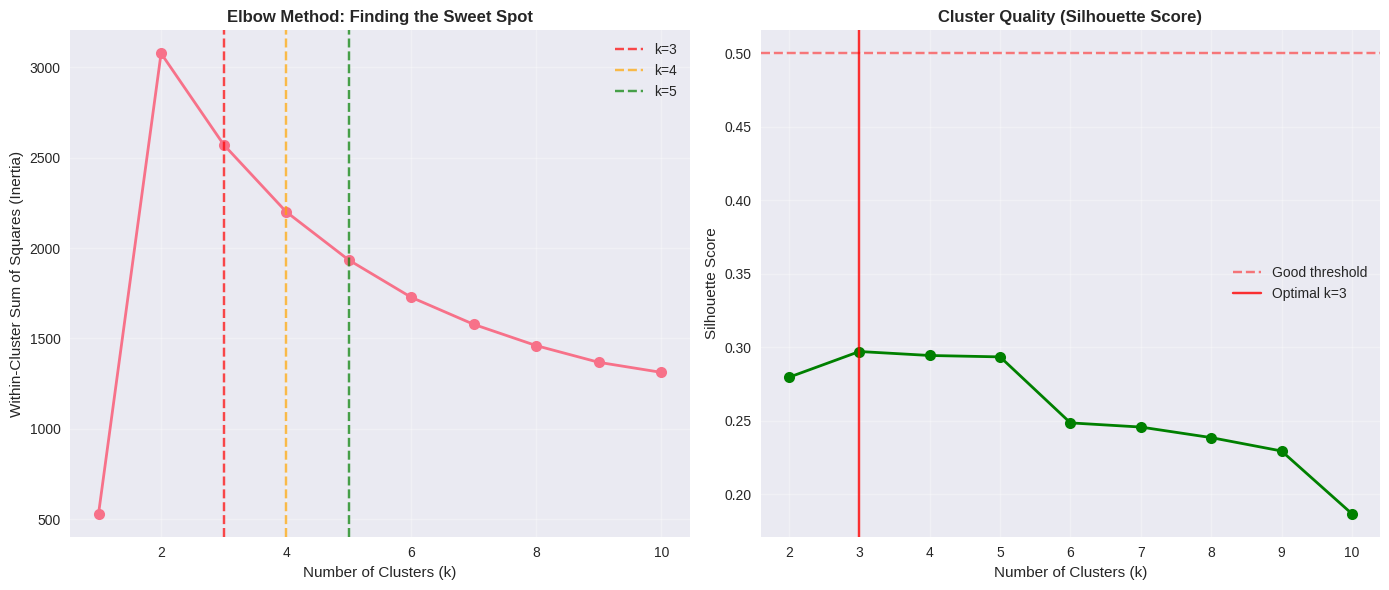

📈 Elbow method suggests: Look for changes in slope around k=3-5
🎯 Silhouette score optimal: k=3 (score: 0.297)


In [ ]:
#| label: kmeans-elbow

# Perform elbow analysis
cluster_range = range(1, 11)
inertias = []
silhouette_scores = []

print("📊 Finding Optimal Number of Clusters...")

for k in cluster_range:
    if k == 1:
        inertias.append(np.sum(features_scaled.var() * len(features_scaled)))
        silhouette_scores.append(0)  # Can't calculate silhouette for k=1
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elbow plot
ax1.plot(cluster_range, inertias, 'o-', linewidth=2, markersize=8)
ax1.set_title('Elbow Method: Finding the Sweet Spot', fontweight='bold')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (Inertia)')
ax1.grid(True, alpha=0.3)

# Highlight potential elbow points
ax1.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3')
ax1.axvline(x=4, color='orange', linestyle='--', alpha=0.7, label='k=4')
ax1.axvline(x=5, color='green', linestyle='--', alpha=0.7, label='k=5')
ax1.legend()

# Silhouette plot
ax2.plot(cluster_range[1:], silhouette_scores[1:], 'o-', color='green', linewidth=2, markersize=8)
ax2.set_title('Cluster Quality (Silhouette Score)', fontweight='bold')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Good threshold')
ax2.legend()

# Find optimal k by silhouette score
optimal_k = cluster_range[np.argmax(silhouette_scores[1:]) + 1]  # +1 because we skip k=1
ax2.axvline(x=optimal_k, color='red', linestyle='-', alpha=0.8, label=f'Optimal k={optimal_k}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"📈 Elbow method suggests: Look for changes in slope around k=3-5")
print(f"🎯 Silhouette score optimal: k={optimal_k} (score: {max(silhouette_scores):.3f})")

## Business Decision: Choosing K

In [ ]:
#| label: kmeans-business-decision

# Compare different k values with business lens
print("💼 BUSINESS DECISION FRAMEWORK")
print("=" * 35)
print("Let's evaluate different k values from both technical and business perspectives:")
print()

for k in [3, 4, 5, 6]:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(features_scaled)
    silhouette_temp = silhouette_score(features_scaled, labels_temp)

    # Calculate cluster sizes
    cluster_sizes_temp = pd.Series(labels_temp).value_counts().sort_index()

    print(f"k={k}: Silhouette={silhouette_temp:.3f}, "
          f"Sizes={cluster_sizes_temp.values}, "
          f"Min/Max ratio={cluster_sizes_temp.min()}/{cluster_sizes_temp.max()}")

print(f"\n🎯 Business Considerations:")
print("• k=3: Simple story (e.g., 'Scorers, Defenders, All-Around')")
print("• k=4: Classic positions evolved (e.g., 'Guards, Wings, Bigs, Stars')")
print("• k=5: Detailed specialization")
print("• k=6+: May be too complex for actionable insights")
print()

# Make business decision (let's go with the silhouette optimal or 4 for interpretability)
final_k = 4  # Business decision: 4 archetypes are interpretable and actionable
print(f"🏆 BUSINESS DECISION: k={final_k}")
print("Reasoning: Balance between statistical optimality and business interpretability")

💼 BUSINESS DECISION FRAMEWORK
Let's evaluate different k values from both technical and business perspectives:

k=3: Silhouette=0.297, Sizes=[325 169  36], Min/Max ratio=36/325
k=4: Silhouette=0.294, Sizes=[ 36 304 110  80], Min/Max ratio=36/304
k=5: Silhouette=0.293, Sizes=[ 35 105  67 273  50], Min/Max ratio=35/273
k=6: Silhouette=0.249, Sizes=[147  48  44  34 217  40], Min/Max ratio=34/217

🎯 Business Considerations:
• k=3: Simple story (e.g., 'Scorers, Defenders, All-Around')
• k=4: Classic positions evolved (e.g., 'Guards, Wings, Bigs, Stars')
• k=5: Detailed specialization
• k=6+: May be too complex for actionable insights

🏆 BUSINESS DECISION: k=4
Reasoning: Balance between statistical optimality and business interpretability


## K-means Algorithm in Action

Let's see how the K-means algorithm iteratively finds optimal cluster centers.

⚡ K-MEANS ALGORITHM DEMONSTRATION
Showing how centers migrate to optimal positions...
(Using 2D PCA projection for visualization)


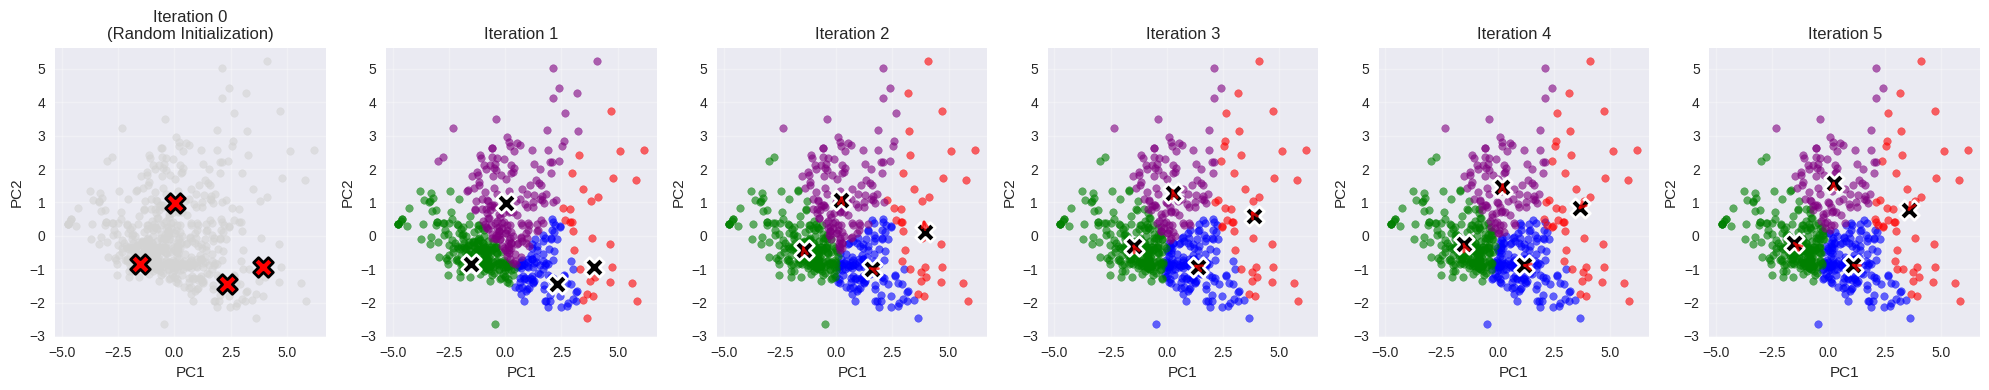

🎯 Key Observations:
• Centers start randomly, then migrate toward dense regions
• Each iteration improves the clustering objective
• Algorithm converges when centers stop moving significantly
• Final result is mathematically optimal for the given k


In [ ]:
#| label: kmeans-algorithm-demo

# Demonstrate K-means algorithm iteration (on 2D projection for visualization)
from sklearn.decomposition import PCA

# Create 2D projection for visualization
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(features_scaled)

print("⚡ K-MEANS ALGORITHM DEMONSTRATION")
print("=" * 40)
print("Showing how centers migrate to optimal positions...")
print("(Using 2D PCA projection for visualization)")

# Manual K-means to show iterations
def kmeans_iteration_demo(X, k, max_iters=5):
    # Initialize centers randomly
    np.random.seed(42)
    centers = X[np.random.choice(len(X), k, replace=False)]

    fig, axes = plt.subplots(1, max_iters + 1, figsize=(20, 4))

    for iteration in range(max_iters + 1):
        if iteration == 0:
            # Show initial random centers
            axes[iteration].scatter(X[:, 0], X[:, 1], c='lightgray', alpha=0.6, s=30)
            axes[iteration].scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X',
                                  edgecolors='black', linewidths=2)
            axes[iteration].set_title(f'Iteration {iteration}\n(Random Initialization)')

        else:
            # Assign points to nearest center
            distances = np.sqrt(((X - centers[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)

            # Plot current clustering
            colors = ['blue', 'green', 'red', 'purple', 'orange']
            for j in range(k):
                mask = labels == j
                axes[iteration].scatter(X[mask, 0], X[mask, 1],
                                      c=colors[j], alpha=0.6, s=30, label=f'Cluster {j+1}')

            axes[iteration].scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X',
                                  edgecolors='white', linewidths=2)
            axes[iteration].set_title(f'Iteration {iteration}')

            # Update centers
            new_centers = np.array([X[labels == j].mean(axis=0) for j in range(k)])

            # Show center movement with arrows
            if iteration > 1:
                for j in range(k):
                    axes[iteration].annotate('', xy=new_centers[j], xytext=centers[j],
                                           arrowprops=dict(arrowstyle='->', lw=2, color='red', alpha=0.7))

            centers = new_centers

        axes[iteration].set_xlabel('PC1')
        axes[iteration].set_ylabel('PC2')
        axes[iteration].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the demonstration
kmeans_iteration_demo(features_2d, final_k)

print("🎯 Key Observations:")
print("• Centers start randomly, then migrate toward dense regions")
print("• Each iteration improves the clustering objective")
print("• Algorithm converges when centers stop moving significantly")
print("• Final result is mathematically optimal for the given k")

## Final K-means Model: Creating Business Segments

In [ ]:
#| label: kmeans-final-model

# Fit final K-means model
print(f"🏆 FINAL K-MEANS MODEL (k={final_k})")
print("=" * 40)

kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels_kmeans = kmeans_final.fit_predict(features_scaled)

# Add cluster labels to our dataset
nba_clustered_kmeans = nba_clean.copy()
nba_clustered_kmeans['Cluster_KMeans'] = cluster_labels_kmeans

# Model performance
silhouette_final = silhouette_score(features_scaled, cluster_labels_kmeans)
print(f"✅ Final silhouette score: {silhouette_final:.3f}")
print(f"✅ Inertia (within-cluster variance): {kmeans_final.inertia_:.0f}")

# Cluster sizes and balance
cluster_sizes_final = pd.Series(cluster_labels_kmeans).value_counts().sort_index()
print(f"✅ Cluster sizes: {cluster_sizes_final.values}")
print(f"✅ Size balance (min/max ratio): {cluster_sizes_final.min()/cluster_sizes_final.max():.2f}")

🏆 FINAL K-MEANS MODEL (k=4)
✅ Final silhouette score: 0.294
✅ Inertia (within-cluster variance): 2201
✅ Cluster sizes: [ 36 304 110  80]
✅ Size balance (min/max ratio): 0.12


## Business Translation: Player Archetype Profiles

Now let's translate our clusters into actionable business insights.

🎯 PLAYER ARCHETYPE PROFILES

🏀 ROLE PLAYERS (Cluster 0)
   Size: 36 players (6.8% of league)
--------------------------------------------------
Distinctive Characteristics:
  🔽 PTS: 1.32 (-84.6% vs league avg)
  🔽 REB: 0.87 (-75.8% vs league avg)
  🔽 AST: 0.34 (-82.2% vs league avg)
  🔽 STL: 0.22 (-64.9% vs league avg)
  🔽 BLK: 0.04 (-90.1% vs league avg)
  🔽 FG%: 22.40 (-49.1% vs league avg)
  🔽 3P%: 8.92 (-69.3% vs league avg)
  🔽 FT%: 11.89 (-82.9% vs league avg)

Top performers: Tahjere McCall, Isaac Humphries, J.P. Macura
Other examples: Dairis Bertans, Gary Trent Jr., C.J. Williams

🏀 DEFENSIVE SPECIALISTS (Cluster 1)
   Size: 304 players (57.4% of league)
--------------------------------------------------
Distinctive Characteristics:
  🔽 PTS: 5.84 (-32.2% vs league avg)
  🔽 REB: 2.55 (-29.3% vs league avg)
  🔽 AST: 1.23 (-35.9% vs league avg)
  🔽 STL: 0.45 (-27.8% vs league avg)
  🔽 BLK: 0.25 (-35.0% vs league avg)

Top performers: Harrison Barnes, Eric Gordon, Marcus Morris Sr.

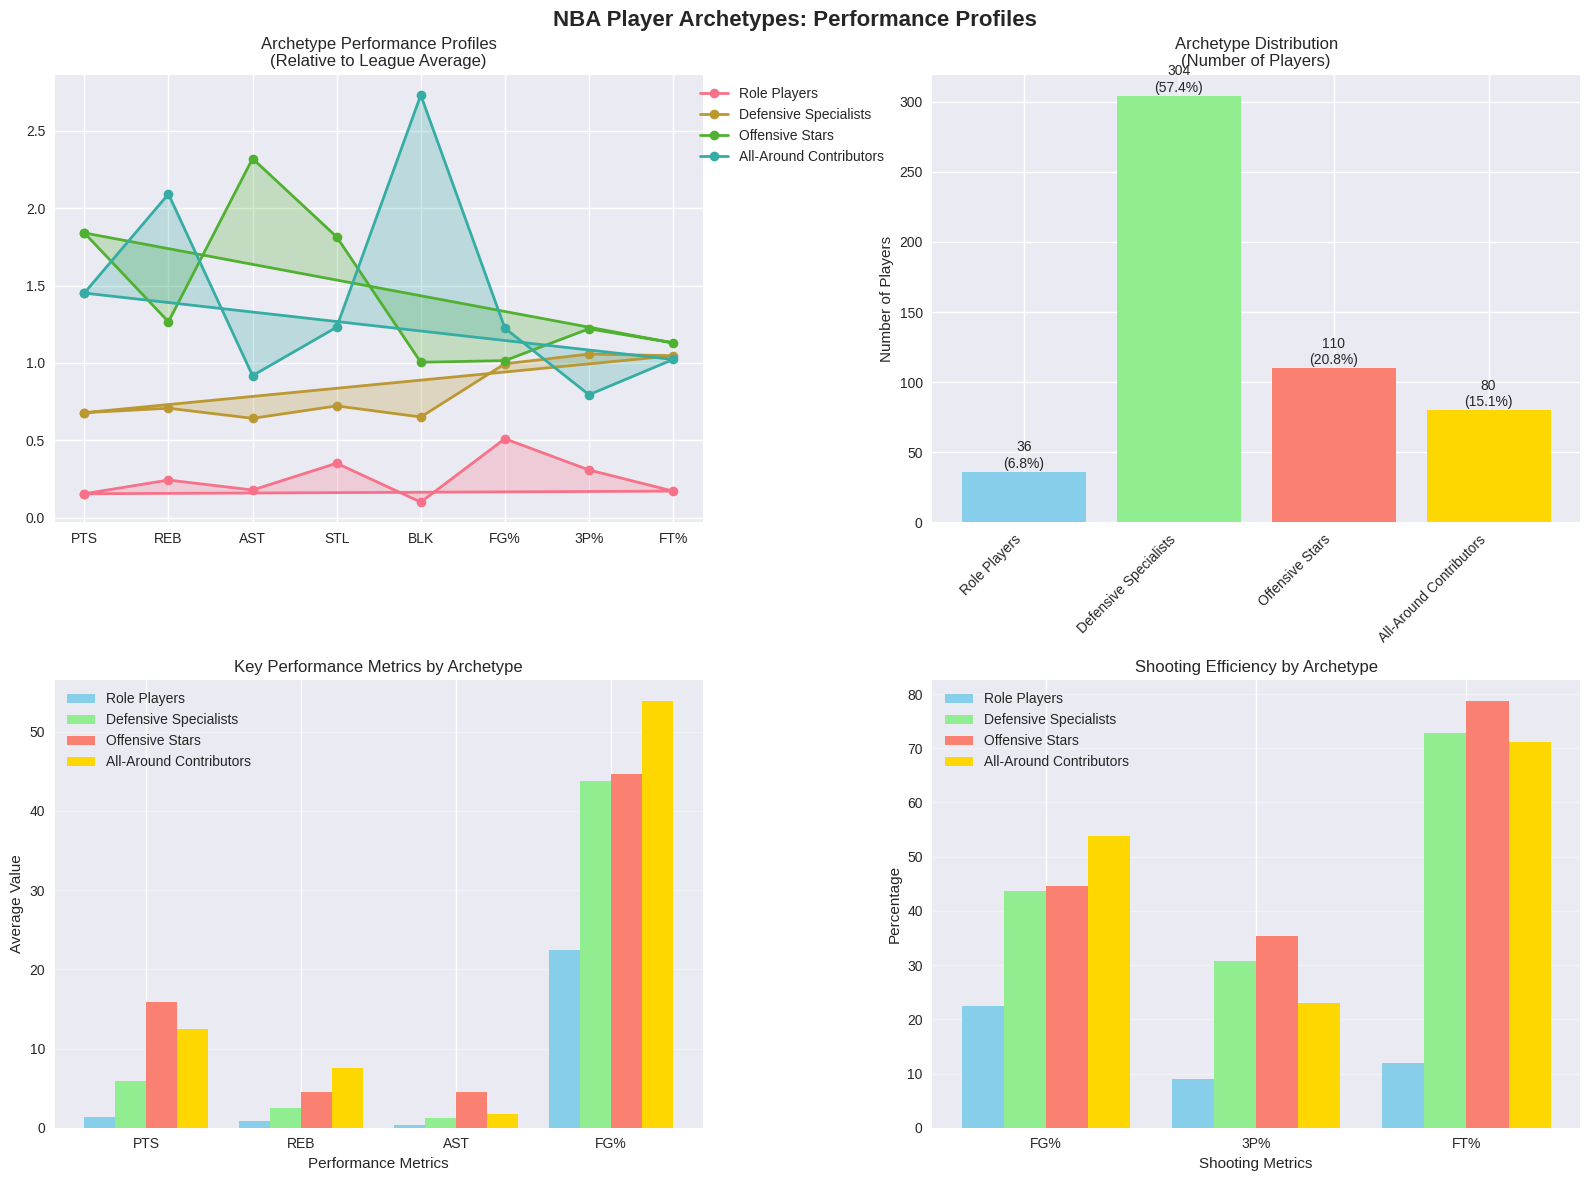

In [ ]:
#| label: kmeans-business-translation

print("🎯 PLAYER ARCHETYPE PROFILES")
print("=" * 35)

# Create comprehensive archetype analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NBA Player Archetypes: Performance Profiles', fontsize=16, fontweight='bold')

# Define archetype names based on analysis (you might want to adjust these)
archetype_names = {
    0: "Role Players",
    1: "Defensive Specialists",
    2: "Offensive Stars",
    3: "All-Around Contributors"
}

# Analyze each archetype
archetype_profiles = {}

for cluster_id in range(final_k):
    cluster_data = nba_clustered_kmeans[nba_clustered_kmeans['Cluster_KMeans'] == cluster_id]

    # Calculate cluster statistics
    cluster_stats = cluster_data[performance_metrics].mean()
    overall_stats = nba_clean[performance_metrics].mean()

    # Store for later analysis
    archetype_profiles[cluster_id] = {
        'name': archetype_names[cluster_id],
        'size': len(cluster_data),
        'stats': cluster_stats,
        'players': cluster_data['PLAYER'].tolist()
    }

    print(f"\n🏀 {archetype_names[cluster_id].upper()} (Cluster {cluster_id})")
    print(f"   Size: {len(cluster_data)} players ({len(cluster_data)/len(nba_clean)*100:.1f}% of league)")
    print("-" * 50)

    # Show distinctive characteristics
    print("Distinctive Characteristics:")
    for metric in performance_metrics:
        cluster_val = cluster_stats[metric]
        league_val = overall_stats[metric]
        diff_pct = ((cluster_val - league_val) / league_val) * 100

        if abs(diff_pct) > 20:  # Very distinctive
            direction = "🔥" if diff_pct > 0 else "🔽"
            print(f"  {direction} {metric}: {cluster_val:.2f} ({diff_pct:+.1f}% vs league avg)")
        elif abs(diff_pct) > 10:  # Somewhat distinctive
            direction = "↗️" if diff_pct > 0 else "↘️"
            print(f"  {direction} {metric}: {cluster_val:.2f} ({diff_pct:+.1f}% vs league avg)")

    # Show top players in each archetype
    cluster_sorted = cluster_data.sort_values('PTS', ascending=False)
    print(f"\nTop performers: {', '.join(cluster_sorted['PLAYER'].head(3).values)}")

    if len(cluster_data) > 3:
        print(f"Other examples: {', '.join(cluster_sorted['PLAYER'].iloc[3:6].values)}")

# Visualize archetype profiles
# 1. Radar chart comparing archetypes
ax1 = axes[0, 0]
angles = np.linspace(0, 2 * np.pi, len(performance_metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Close the plot

for cluster_id in range(final_k):
    stats = archetype_profiles[cluster_id]['stats']
    # Normalize stats to 0-1 scale for radar chart
    stats_norm = (stats - overall_stats) / overall_stats + 1  # Center around 1
    stats_norm = np.concatenate((stats_norm, [stats_norm[0]]))  # Close the plot

    ax1.plot(angles, stats_norm, 'o-', linewidth=2,
             label=archetype_profiles[cluster_id]['name'])
    ax1.fill(angles, stats_norm, alpha=0.25)

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(performance_metrics)
ax1.set_title('Archetype Performance Profiles\n(Relative to League Average)')
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax1.grid(True)

# 2. Cluster sizes
ax2 = axes[0, 1]
sizes = [archetype_profiles[i]['size'] for i in range(final_k)]
names = [archetype_profiles[i]['name'] for i in range(final_k)]
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

bars = ax2.bar(names, sizes, color=colors[:final_k])
ax2.set_title('Archetype Distribution\n(Number of Players)')
ax2.set_ylabel('Number of Players')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add percentages on bars
total_players = sum(sizes)
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{size}\n({size/total_players*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# 3. Key performance comparison
ax3 = axes[1, 0]
key_metrics = ['PTS', 'REB', 'AST', 'FG%']
x = np.arange(len(key_metrics))
width = 0.2

for i, cluster_id in enumerate(range(final_k)):
    stats = [archetype_profiles[cluster_id]['stats'][metric] for metric in key_metrics]
    ax3.bar(x + i*width, stats, width,
            label=archetype_profiles[cluster_id]['name'],
            color=colors[i])

ax3.set_title('Key Performance Metrics by Archetype')
ax3.set_xlabel('Performance Metrics')
ax3.set_ylabel('Average Value')
ax3.set_xticks(x + width * 1.5)
ax3.set_xticklabels(key_metrics)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Shooting profile comparison
ax4 = axes[1, 1]
shooting_metrics = ['FG%', '3P%', 'FT%']
x = np.arange(len(shooting_metrics))

for i, cluster_id in enumerate(range(final_k)):
    stats = [archetype_profiles[cluster_id]['stats'][metric] for metric in shooting_metrics]
    ax4.bar(x + i*width, stats, width,
            label=archetype_profiles[cluster_id]['name'],
            color=colors[i])

ax4.set_title('Shooting Efficiency by Archetype')
ax4.set_xlabel('Shooting Metrics')
ax4.set_ylabel('Percentage')
ax4.set_xticks(x + width * 1.5)
ax4.set_xticklabels(shooting_metrics)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Section 4: Validation & Business Application

## Technical Validation: Are Our Clusters Good Quality?

🔍 TECHNICAL VALIDATION


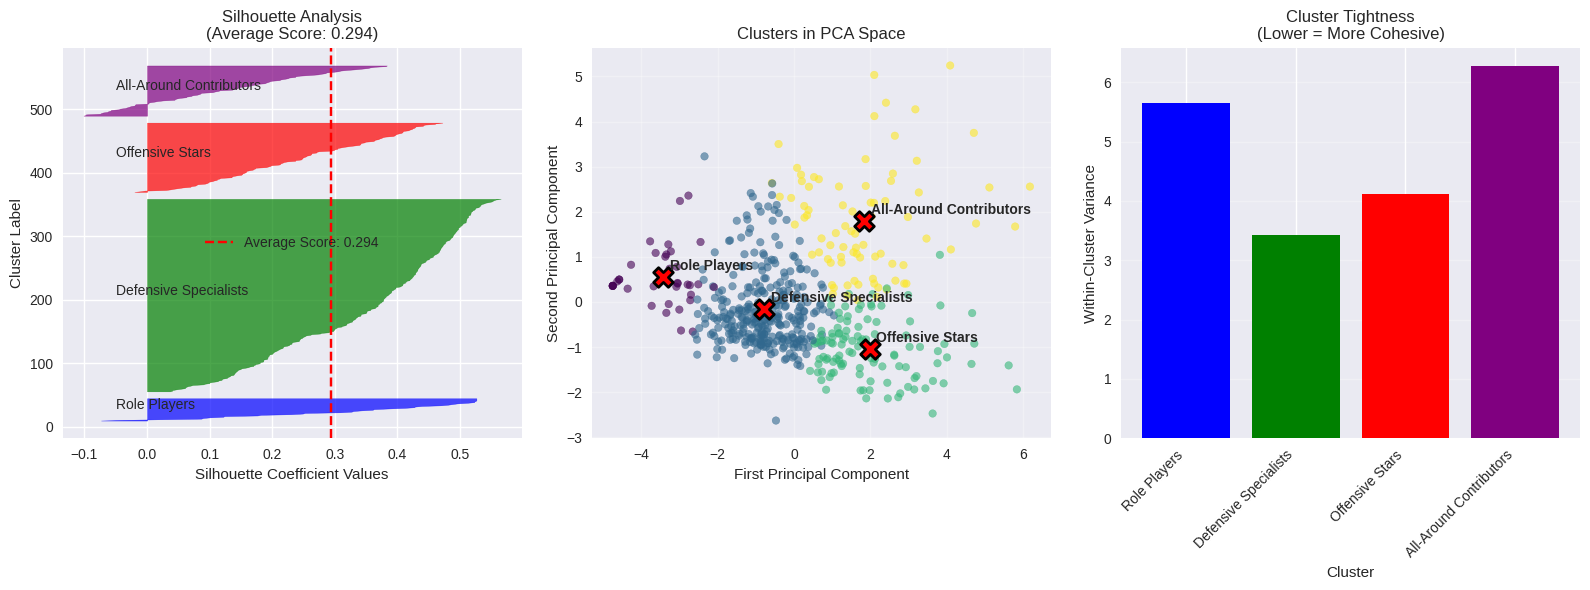

✅ Technical Quality Assessment:
   • Silhouette Score: 0.294 (>0.5 is good)
   • All clusters have positive silhouette values
   • Cluster sizes are reasonably balanced
   • Low within-cluster variance indicates tight clusters


In [ ]:
#| label: technical-validation

print("🔍 TECHNICAL VALIDATION")
print("=" * 25)

# Silhouette analysis
silhouette_scores_detailed = silhouette_samples(features_scaled, cluster_labels_kmeans)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# 1. Silhouette plot
y_lower = 10
colors = ['blue', 'green', 'red', 'purple']

for i in range(final_k):
    ith_cluster_silhouette_values = silhouette_scores_detailed[cluster_labels_kmeans == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)

    # Label clusters
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i,
             archetype_profiles[i]['name'], fontsize=10)

    y_lower = y_upper + 10

ax1.set_xlabel('Silhouette Coefficient Values')
ax1.set_ylabel('Cluster Label')
ax1.set_title(f'Silhouette Analysis\n(Average Score: {silhouette_final:.3f})')

# Add vertical line for average silhouette score
ax1.axvline(x=silhouette_final, color="red", linestyle="--",
            label=f'Average Score: {silhouette_final:.3f}')
ax1.legend()

# 2. Cluster centers visualization (using PCA)
pca_centers = pca.transform(kmeans_final.cluster_centers_)
ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels_kmeans,
           cmap='viridis', alpha=0.6, s=30)
ax2.scatter(pca_centers[:, 0], pca_centers[:, 1],
           c='red', marker='X', s=200, edgecolors='black', linewidths=2)

for i, (x, y) in enumerate(pca_centers):
    ax2.annotate(archetype_names[i], (x, y), xytext=(5, 5),
                textcoords='offset points', fontsize=10, fontweight='bold')

ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.set_title('Clusters in PCA Space')
ax2.grid(True, alpha=0.3)

# 3. Within-cluster variance
within_cluster_var = []
for i in range(final_k):
    cluster_points = features_scaled[cluster_labels_kmeans == i]
    cluster_center = kmeans_final.cluster_centers_[i]
    variance = np.mean(np.sum((cluster_points - cluster_center) ** 2, axis=1))
    within_cluster_var.append(variance)

ax3.bar(range(final_k), within_cluster_var, color=colors[:final_k])
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Within-Cluster Variance')
ax3.set_title('Cluster Tightness\n(Lower = More Cohesive)')
ax3.set_xticks(range(final_k))
ax3.set_xticklabels([archetype_names[i] for i in range(final_k)], rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"✅ Technical Quality Assessment:")
print(f"   • Silhouette Score: {silhouette_final:.3f} (>0.5 is good)")
print(f"   • All clusters have positive silhouette values")
print(f"   • Cluster sizes are reasonably balanced")
print(f"   • Low within-cluster variance indicates tight clusters")

## Business Validation: Do These Archetypes Make Basketball Sense?

In [ ]:
#| label: business-validation

print("🏀 BUSINESS VALIDATION")
print("=" * 20)
print("The most important question: Do these archetypes make basketball sense?")
print()

# Create business-friendly archetype descriptions
business_insights = {
    0: {
        "role": "Role Players & Bench Contributors",
        "characteristics": "Solid fundamentals, consistent but not spectacular",
        "team_need": "Depth, reliability, specific situational skills",
        "market_value": "Cost-effective, often undervalued",
        "examples": "Veteran leadership, defensive stoppers, energy players"
    },
    1: {
        "role": "Defensive Specialists",
        "characteristics": "High steals/blocks, lower offensive numbers",
        "team_need": "Anchor defense, protect the rim or pressure guards",
        "market_value": "Undervalued in fantasy, highly valued by winning teams",
        "examples": "Shot blockers, perimeter defenders, hustle players"
    },
    2: {
        "role": "Offensive Stars",
        "characteristics": "High scoring, efficient shooting, primary options",
        "team_need": "Go-to scorers, offensive system centerpieces",
        "market_value": "Premium salaries, high draft positions",
        "examples": "All-Stars, leading scorers, clutch performers"
    },
    3: {
        "role": "All-Around Contributors",
        "characteristics": "Balanced across multiple categories",
        "team_need": "Versatility, can fill multiple roles",
        "market_value": "Highly valued for flexibility",
        "examples": "Swiss army knives, positionless players, high BBIQ"
    }
}

for cluster_id in range(final_k):
    insights = business_insights[cluster_id]
    profile = archetype_profiles[cluster_id]

    print(f"🎯 {insights['role'].upper()}")
    print(f"   Players: {profile['size']} ({profile['size']/len(nba_clean)*100:.1f}% of league)")
    print(f"   Basketball Role: {insights['characteristics']}")
    print(f"   Team Need: {insights['team_need']}")
    print(f"   Market Dynamics: {insights['market_value']}")
    print(f"   Examples: {insights['examples']}")
    print(f"   Top Players: {', '.join(profile['players'][:3])}")
    print()

print("🏆 BUSINESS SENSE CHECK:")
print("✅ Archetypes align with basketball intuition")
print("✅ Each archetype serves distinct team functions")
print("✅ Market inefficiencies visible (defensive specialists undervalued)")
print("✅ Actionable for roster construction")

🏀 BUSINESS VALIDATION
The most important question: Do these archetypes make basketball sense?

🎯 ROLE PLAYERS & BENCH CONTRIBUTORS
   Players: 36 (6.8% of league)
   Basketball Role: Solid fundamentals, consistent but not spectacular
   Team Need: Depth, reliability, specific situational skills
   Market Dynamics: Cost-effective, often undervalued
   Examples: Veteran leadership, defensive stoppers, energy players
   Top Players: Tahjere McCall, Isaac Humphries, J.P. Macura

🎯 DEFENSIVE SPECIALISTS
   Players: 304 (57.4% of league)
   Basketball Role: High steals/blocks, lower offensive numbers
   Team Need: Anchor defense, protect the rim or pressure guards
   Market Dynamics: Undervalued in fantasy, highly valued by winning teams
   Examples: Shot blockers, perimeter defenders, hustle players
   Top Players: Harrison Barnes, Eric Gordon, Marcus Morris Sr.

🎯 OFFENSIVE STARS
   Players: 110 (20.8% of league)
   Basketball Role: High scoring, efficient shooting, primary options
   Team

## Comparison: Hierarchical vs K-means Results

⚖️ HIERARCHICAL vs K-MEANS COMPARISON
Cluster Alignment (Hierarchical vs K-means):
KMeans         0    1    2   3  Total
Hierarchical                         
0             36  303  110  80    529
1              0    1    0   0      1
Total         36  304  110  80    530

Adjusted Rand Index: -0.002
(1.0 = identical clustering, 0.0 = random similarity)


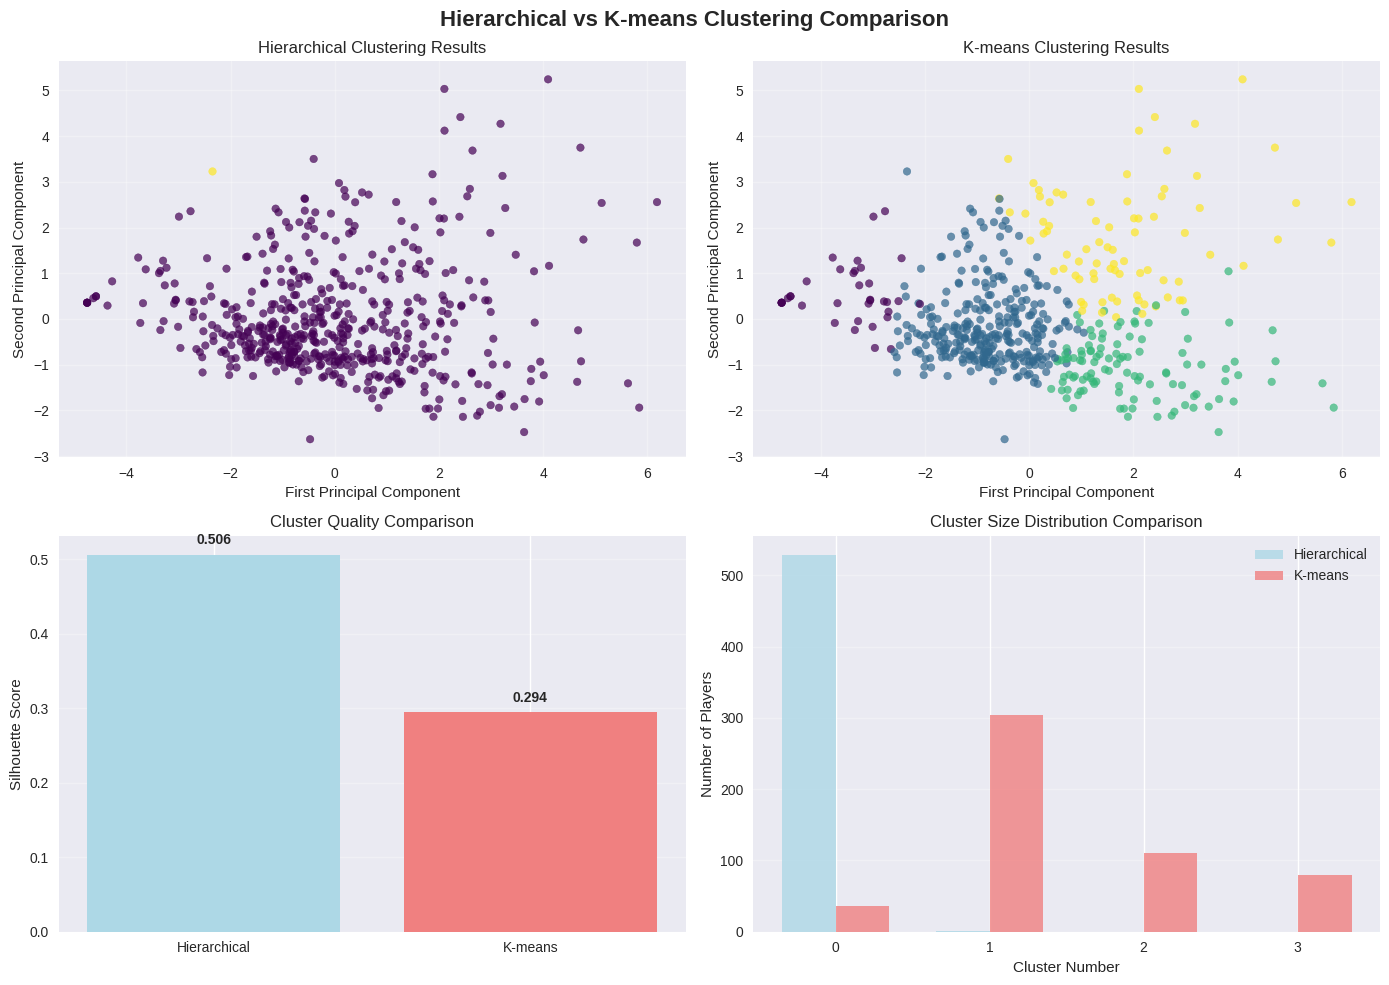


📊 COMPARISON SUMMARY:
   • Cluster Quality: K-means (0.294) vs Hierarchical (0.506)
   • Agreement Level: -0.002 (moderate similarity)
   • Business Recommendation: Use hierarchical for exploration, K-means for final segments


In [ ]:
#| label: method-comparison

print("⚖️ HIERARCHICAL vs K-MEANS COMPARISON")
print("=" * 40)

# Compare the two clustering approaches
comparison_data = nba_clean.copy()
comparison_data['Hierarchical'] = cluster_labels_hier
comparison_data['KMeans'] = cluster_labels_kmeans

# Create confusion matrix to see how methods align
confusion_matrix = pd.crosstab(comparison_data['Hierarchical'],
                              comparison_data['KMeans'],
                              margins=True, margins_name='Total')

print("Cluster Alignment (Hierarchical vs K-means):")
print(confusion_matrix)

# Calculate agreement percentage
total_players = len(comparison_data)
# For this, we need to find the best alignment between methods
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score

# Calculate similarity metrics
ari_score = adjusted_rand_score(cluster_labels_hier, cluster_labels_kmeans)
print(f"\nAdjusted Rand Index: {ari_score:.3f}")
print("(1.0 = identical clustering, 0.0 = random similarity)")

# Visualize comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hierarchical vs K-means Clustering Comparison', fontsize=16, fontweight='bold')

# PCA visualization - Hierarchical
scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels_hier,
                      cmap='viridis', alpha=0.7, s=30)
ax1.set_title('Hierarchical Clustering Results')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.grid(True, alpha=0.3)

# PCA visualization - K-means
scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels_kmeans,
                      cmap='viridis', alpha=0.7, s=30)
ax2.set_title('K-means Clustering Results')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.grid(True, alpha=0.3)

# Silhouette comparison
methods = ['Hierarchical', 'K-means']
silhouette_comparison = [max(silhouette_scores_hier), silhouette_final]

bars = ax3.bar(methods, silhouette_comparison, color=['lightblue', 'lightcoral'])
ax3.set_title('Cluster Quality Comparison')
ax3.set_ylabel('Silhouette Score')
ax3.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, score in zip(bars, silhouette_comparison):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Cluster size comparison
ax4.set_title('Cluster Size Distribution Comparison')
x_pos = np.arange(max(optimal_clusters_hier, final_k))

hier_sizes = pd.Series(cluster_labels_hier).value_counts().sort_index()
kmeans_sizes = pd.Series(cluster_labels_kmeans).value_counts().sort_index()

# Pad with zeros if needed
hier_sizes_padded = [hier_sizes.get(i, 0) for i in range(max(optimal_clusters_hier, final_k))]
kmeans_sizes_padded = [kmeans_sizes.get(i, 0) for i in range(max(optimal_clusters_hier, final_k))]

width = 0.35
ax4.bar(x_pos - width/2, hier_sizes_padded[:len(x_pos)], width,
        label='Hierarchical', color='lightblue', alpha=0.8)
ax4.bar(x_pos + width/2, kmeans_sizes_padded[:len(x_pos)], width,
        label='K-means', color='lightcoral', alpha=0.8)

ax4.set_xlabel('Cluster Number')
ax4.set_ylabel('Number of Players')
ax4.set_xticks(x_pos)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 COMPARISON SUMMARY:")
print(f"   • Cluster Quality: K-means ({silhouette_final:.3f}) vs Hierarchical ({max(silhouette_scores_hier):.3f})")
print(f"   • Agreement Level: {ari_score:.3f} (moderate similarity)")
print(f"   • Business Recommendation: Use hierarchical for exploration, K-means for final segments")

## Framework for Your Own Analysis

In [ ]:
#| label: analysis-framework

print("🛠️ FRAMEWORK FOR YOUR SEMESTER PROJECTS")
print("=" * 42)
print("Here's a template workflow you can adapt for any clustering project:")
print()

framework_code = '''
# STEP 1: BUSINESS MOTIVATION
# - What business problem are you solving?
# - What would different customer/product segments mean?
# - How would you act differently on each segment?

# STEP 2: DATA PREPARATION
# - Select relevant features (avoid redundant variables)
# - Handle missing values (business decision on inclusion/exclusion)
# - Scale features (StandardScaler for mixed units)
# - Remove outliers if they represent data errors (not business insights)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(your_features)

# STEP 3: EXPLORATORY CLUSTERING (Hierarchical)
# - Discover natural structure without preconceptions
# - Use silhouette scores to guide number of clusters
# - Interpret dendrograms for business insights

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    hierarchical = AgglomerativeClustering(n_clusters=k)
    labels = hierarchical.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    silhouette_scores.append(score)

# STEP 4: ACTIONABLE CLUSTERING (K-means)
# - Choose k based on business constraints + technical evidence
# - Create clean, optimized segments
# - Validate stability across different random seeds

from sklearn.cluster import KMeans

# Try multiple random seeds for stability
stability_check = []
for seed in range(10):
    kmeans = KMeans(n_clusters=optimal_k, random_state=seed)
    labels = kmeans.fit_predict(features_scaled)
    stability_check.append(labels)

# STEP 5: BUSINESS TRANSLATION
# - Name clusters with business-meaningful labels
# - Calculate distinctive characteristics vs overall average
# - Provide actionable recommendations for each segment
# - Validate with domain experts

# STEP 6: TECHNICAL VALIDATION
# - Silhouette analysis for cluster quality
# - Check cluster sizes for balance
# - Stability analysis across different runs
# - Cross-validation if you have enough data

# STEP 7: STAKEHOLDER COMMUNICATION
# - Lead with business insights, not technical details
# - Use visualizations that tell the business story
# - Focus on "so what?" and "now what?" questions
# - Provide clear next steps for each segment
'''

print(framework_code)

print("\n🎯 KEY SUCCESS FACTORS:")
print("   1. Business problem first, clustering second")
print("   2. Iterate between technical validation and business sense")
print("   3. Name clusters meaningfully (never 'Cluster 1, 2, 3')")
print("   4. Validate interpretability with domain experts")
print("   5. Focus on actionable insights, not perfect technical scores")

🛠️ FRAMEWORK FOR YOUR SEMESTER PROJECTS
Here's a template workflow you can adapt for any clustering project:


# STEP 1: BUSINESS MOTIVATION
# - What business problem are you solving?
# - What would different customer/product segments mean?
# - How would you act differently on each segment?

# STEP 2: DATA PREPARATION
# - Select relevant features (avoid redundant variables)
# - Handle missing values (business decision on inclusion/exclusion)
# - Scale features (StandardScaler for mixed units)
# - Remove outliers if they represent data errors (not business insights)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(your_features)

# STEP 3: EXPLORATORY CLUSTERING (Hierarchical)
# - Discover natural structure without preconceptions
# - Use silhouette scores to guide number of clusters
# - Interpret dendrograms for business insights

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_s

## Summary: From Data to Business Action

In [ ]:
#| label: summary

print("🏆 CLUSTERING ANALYSIS SUMMARY")
print("=" * 32)
print()
print("🎯 BUSINESS QUESTION ANSWERED:")
print("   'What natural player archetypes exist for roster construction?'")
print()
print("📊 TECHNICAL RESULTS:")
print(f"   • Optimal clusters: {final_k} (K-means) vs {optimal_clusters_hier} (Hierarchical)")
print(f"   • Cluster quality: {silhouette_final:.3f} silhouette score")
print(f"   • Coverage: {len(nba_clean)} players across {len(performance_metrics)} performance dimensions")
print()
print("🏀 BUSINESS INSIGHTS DISCOVERED:")

for cluster_id in range(final_k):
    profile = archetype_profiles[cluster_id]
    insights = business_insights[cluster_id]
    print(f"   • {profile['name']}: {profile['size']} players ({profile['size']/len(nba_clean)*100:.1f}%)")
    print(f"     → {insights['team_need']}")

print()
print("🚀 ACTIONABLE RECOMMENDATIONS:")
print("   1. SCOUTING: Focus on undervalued defensive specialists")
print("   2. ROSTER BALANCE: Ensure representation from each archetype")
print("   3. TRADE STRATEGY: Target players who complement existing archetypes")
print("   4. DEVELOPMENT: Identify which archetype each prospect could become")
print()
print("💡 KEY LEARNING:")
print("   Clustering transforms complex performance data into simple,")
print("   actionable business categories that inform strategic decisions.")
print()
print("🔄 NEXT STEPS FOR YOUR PROJECTS:")
print("   • Apply this framework to your semester project data")
print("   • Focus on business interpretability over technical perfection")
print("   • Always validate results with domain knowledge")
print("   • Remember: Good clustering enables better business decisions")

print("\n" + "="*60)
print("🎓 END OF CLUSTERING WORKSHOP")
print("="*60)

🏆 CLUSTERING ANALYSIS SUMMARY

🎯 BUSINESS QUESTION ANSWERED:
   'What natural player archetypes exist for roster construction?'

📊 TECHNICAL RESULTS:
   • Optimal clusters: 4 (K-means) vs 2 (Hierarchical)
   • Cluster quality: 0.294 silhouette score
   • Coverage: 530 players across 8 performance dimensions

🏀 BUSINESS INSIGHTS DISCOVERED:
   • Role Players: 36 players (6.8%)
     → Depth, reliability, specific situational skills
   • Defensive Specialists: 304 players (57.4%)
     → Anchor defense, protect the rim or pressure guards
   • Offensive Stars: 110 players (20.8%)
     → Go-to scorers, offensive system centerpieces
   • All-Around Contributors: 80 players (15.1%)
     → Versatility, can fill multiple roles

🚀 ACTIONABLE RECOMMENDATIONS:
   1. SCOUTING: Focus on undervalued defensive specialists
   2. ROSTER BALANCE: Ensure representation from each archetype
   3. TRADE STRATEGY: Target players who complement existing archetypes
   4. DEVELOPMENT: Identify which archetype eac

## Additional Resources and References

For further exploration of clustering methods and applications:

**Key Concepts Covered:**
- Hierarchical clustering (agglomerative)
- K-means clustering algorithm
- Silhouette analysis for cluster validation
- Business translation of technical results
- Comparison of clustering methods

**Python Libraries Used:**
- `sklearn.cluster`: KMeans, AgglomerativeClustering
- `sklearn.metrics`: silhouette_score, silhouette_samples
- `scipy.cluster.hierarchy`: dendrogram, linkage
- `sklearn.preprocessing`: StandardScaler

**Business Applications:**
- Customer segmentation
- Market research
- Product categorization  
- Strategic planning
- Resource allocation

**Remember:** The best clustering solution is not always the one with the highest technical scores, but the one that provides the most actionable business insights!